In [2]:
import torch
import numpy as np
from matplotlib import pyplot as plt

import torch.nn.functional as F

In [126]:
names = open("names.txt", "r").read().splitlines()
chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(stoi)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [127]:
def build_dataset(names):
    block_size = 3 #context length of how many chars we take to predict the next char
    X, Y = [],[]
    
    for w in names:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # rolling window, makes sense when you run it
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

In [128]:

import random
random.seed(42)
random.shuffle(names)
X_train, Y_train = build_dataset(names[:int(0.8*len(names))]) #get first 80% of the dataset
X_valid, Y_valid = build_dataset(names[int(0.8*len(names)):int(0.9*len(names))]) # get between 80%-90%
X_test, Y_test = build_dataset(names[int(0.9*len(names)):]) # get last 10% of dataset

In [129]:
X_train.shape, X_valid.shape, X_test.shape

(torch.Size([182625, 3]), torch.Size([22655, 3]), torch.Size([22866, 3]))

##### ======================================
#### We want our probabilities that get fed into softmax to be 100% uniform on the 1st run, that is because the lowest probability for each char should be 1/27. 
#### When we calculate the loss with logits and Y_train[x], we get loss=27, which should be ~3.29 according to our cross entropy loss calculation. So we want uniform logits, how do we do that? If all logits would be close to 0, they'd all roughly be equal, so let's try to not add bias (*0), and reduce our weights for the last layer (*0.01). Now, we start with loss=3.31 !!
-------------

#### Now, we also have a problem with our tanh function. Most values by far, take values very very close to -1 and 1. This means that the gradient for these activations is 0. Let's check below how often our h (activation) is in that flat region of tanh. Run below cell only after forward/backward cell which is below. In all white cells, the gradient would be squashed to 0, leading to dead potentially dead neurons (neurons that always have gradient 0 and thus never learn for all 32 examples)
#### To fix this, we obviously need to make sure that our activations (h) is not -1 or 1 or really close to those. We can also try to reduce the bias and weights in the first layer. Boom! No more white neurons that have 0 gradients. Setting weights and biases closer to 0 helped!
-------------

#### Now, let's not magically "weight" to 0 as it doesn't seem like a great idea. Let's do something more professional: set them to be Gaussian.

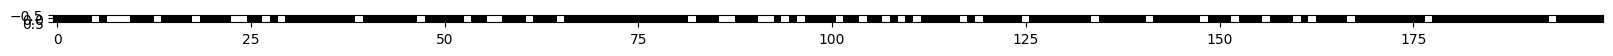

In [130]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")
# activation for all 200 neurons, for the 32 batch examples.

In [118]:
print(-torch.tensor([1/27]).log())

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator=g)
W1 = torch.randn((30,200), generator=g) * (5/3 / (W1.shape[0]**0.5))
                                            # each neuron here will get #features inputs. = emb.view(-1, emb_cols) = whatever,30
#b1 = torch.randn(200, generator=g) * 0.01
W2 = torch.randn((200,27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0

gamma = torch.ones((1, W1.shape[1]))
beta = torch.zeros((1, W1.shape[1]))

mean_running = torch.zeros((1, W1.shape[1]))
std_running = torch.ones((1, W1.shape[1]))

params = [C, W1, W2, b2, gamma, beta]

tensor([3.2958])


In [119]:
for p in params:
    p.requires_grad=True

In [120]:
lossi = []
stepi = []

In [132]:
eps = 1e-5
for i in range(100000):
    #forward pass
    ix = torch.randint(0,X_train.shape[0],(32,))
    emb = C[X_train[ix]]
    embinput = emb.view(-1,W1.shape[0])
    hpreact = embinput @ W1
    mean_i = hpreact.mean(dim=0,keepdims=True)
    std_i = hpreact.std(dim=0,keepdims=True) + eps
    hpreact = gamma*(hpreact - mean_i) / std_i + beta

    with torch.no_grad():
        mean_running = mean_running*(1-0.001) + mean_i*(0.001)
        std_running = std_running*(1-0.001) + std_i*(0.001)

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 # output from our network
    loss = F.cross_entropy(logits, Y_train[ix])
    
    # backward pass
    # zero out all gradients
    for p in params:
        p.grad = None # same as setting to 0
    loss.backward()
    
    lr = 0.1 if i<80000 else 0.001 #decayed it to 0.001 from 0.1 after 3 iters of this. Loss: 2.5 -> 2.6 -> 2.2 -> 1.86
    for p in params:
        p.data += -lr*p.grad

    # track stats
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
print(loss)

tensor(2.3941, grad_fn=<NllLossBackward0>)


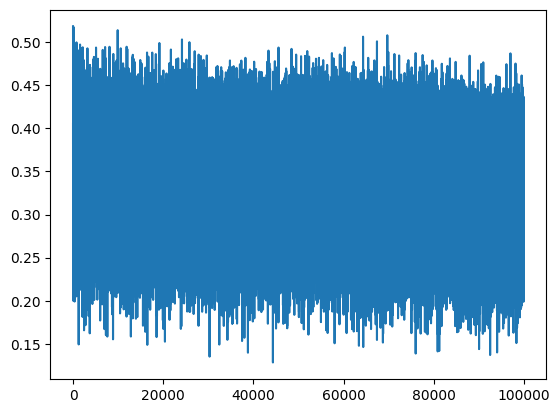

In [133]:
# plot the different learning rates
#------------

plt.plot(stepi, lossi)

In [123]:
# eval loss on full training data set after training
#------------

emb = C[X_train]
embinput = emb.view(-1,emb_cols)
hpreact = embinput @ W1
hpreact = gamma*((hpreact - mean_running) / (std_running + eps)) + beta
h = torch.tanh(hpreact)
logits = h @ W2 + b2 # output from our network
loss = F.cross_entropy(logits, Y_train)
print(loss)

tensor(2.0847, grad_fn=<NllLossBackward0>)


In [124]:
# eval loss on full validation data set after training
#------------

emb = C[X_test]
embinput = emb.view(-1,emb_cols)
hpreact = embinput @ W1
hpreact = gamma*((hpreact - mean_running) / (std_running + eps)) + beta
h = torch.tanh(hpreact)
logits = h @ W2 + b2 # output from our network
loss = F.cross_entropy(logits, Y_test)
print(loss)

tensor(2.1266, grad_fn=<NllLossBackward0>)


In [138]:
# To end this off, let's sample from the model
#------------

block_size = 3
g = torch.Generator().manual_seed(2147483647+10)
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # before it was (size of X, embedding vector dimension), but now we just need 1 example
        embinput = emb.view(-1)
        hpreact = embinput @ W1
        hpreact = gamma*((hpreact - mean_running) / (std_running + eps)) + beta
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits,dim=1) # same as before, exponentiates, makes them sum to 1
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix] # sliding window again
        out.append(ix)
        if(ix == 0):
            break
    print(''.join(itos[i] for i in out))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (3x10 and 30x200)